In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
comp_pre = jx.Compartment()
branch_pre = jx.Branch(comp_pre, ncomp=1)
parents_pre = np.asarray([-1])           
cell_pre = jx.Cell(branch_pre, parents=parents_pre)

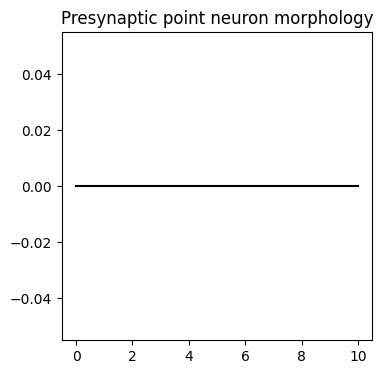

In [4]:
cell_pre.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_pre.vis(ax=ax)
ax.set_title("Presynaptic point neuron morphology");

In [5]:
n_post_comp = 15
comp_post = jx.Compartment()
branch_post = jx.Branch(comp_post, ncomp=n_post_comp)   
parents_post = np.asarray([-1])          
cell_post = jx.Cell(branch_post, parents=parents_post)

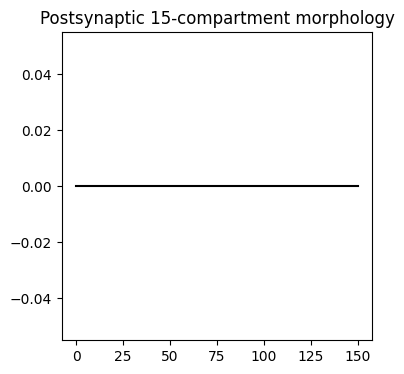

In [6]:
cell_post.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell_post.vis(ax=ax)
ax.set_title("Postsynaptic 15-compartment morphology");

In [7]:
num_pre = 8                    
pre_cells = [cell_pre for _ in range(num_pre)]
cells = pre_cells + [cell_post]
net = jx.Network(cells)


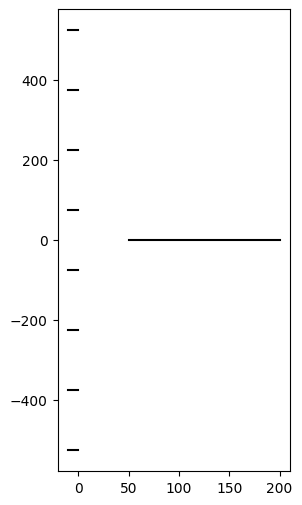

In [8]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[num_pre, 1], within_layer_offset=150, between_layer_offset=200)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

In [9]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [10]:
syn = IonotropicSynapse()
post_idx = num_pre

post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

for pre_idx, comp_idx in zip(range(num_pre), post_comp_indices):
    pre_comp  = net.cell(pre_idx).branch(0).comp(0)           # presyn soma
    post_comp = net.cell(post_idx).branch(0).comp(int(comp_idx))
    connect(pre_comp, post_comp, syn)

print("Ionotropic edges:", net.IonotropicSynapse.edges.shape)

Ionotropic edges: (8, 16)


ABOVE SHOULD YIELD (8, 16) NEED TO FIX BC RE RUNNING ADDS UNOBSERVABLE EDGES

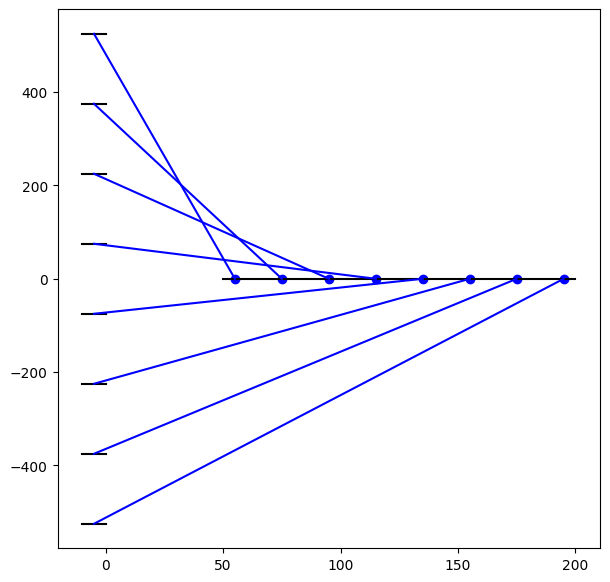

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = net.vis(ax=ax, detail="full")

In [12]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,8,IonotropicSynapse,0,0.5,0.033333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,1,10,IonotropicSynapse,0,0.5,0.166667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,2,12,IonotropicSynapse,0,0.5,0.300000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,3,14,IonotropicSynapse,0,0.5,0.433333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,4,16,IonotropicSynapse,0,0.5,0.566667,0.0001,0.0,0.025,-35.0,10.0,0.2,0
5,5,5,5,18,IonotropicSynapse,0,0.5,0.700000,0.0001,0.0,0.025,-35.0,10.0,0.2,0
6,6,6,6,20,IonotropicSynapse,0,0.5,0.833333,0.0001,0.0,0.025,-35.0,10.0,0.2,0
7,7,7,7,22,IonotropicSynapse,0,0.5,0.966667,0.0001,0.0,0.025,-35.0,10.0,0.2,0


In [13]:
# net.set("IonotropicSynapse_gS", 0.0005)
# net.edges

In [14]:
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 50.0  # ms

In [15]:
time_vec = np.arange(0.0, t_max + dt, dt)

In [16]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(num_pre):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


In [17]:
net.delete_recordings()
# net.cell(post_idx).branch(0).loc(0.0).record()
post_branch = net.cell(post_idx).branch(0)
locs = np.linspace(0.0, 1.0, n_post_comp) 
post_branch.loc(locs).record()



Added 15 recordings. See `.recordings` for details.


In [18]:
traces = jx.integrate(net, delta_t=dt)

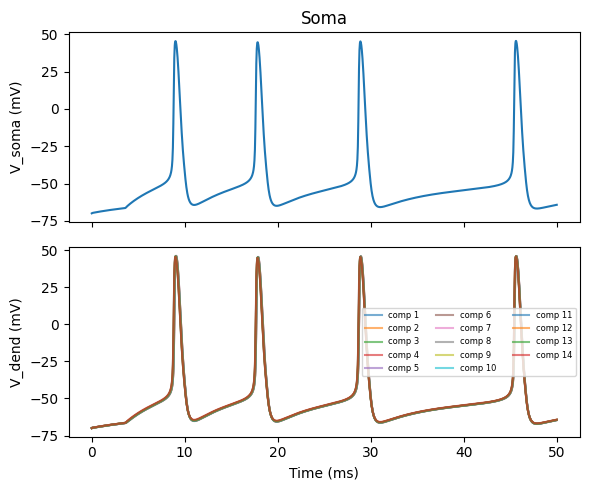

In [19]:
soma_trace = traces[0]
dend_traces  = traces[1:, :]  

T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

# soma
axes[0].plot(time_vec, soma_trace)
axes[0].set_ylabel("V_soma (mV)")
axes[0].set_title("Soma")

# dendrites
for i in range(dend_traces.shape[0]):
    axes[1].plot(time_vec, dend_traces[i], alpha=0.6, label=f"comp {i+1}")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("V_dend (mV)")
axes[1].legend(fontsize=6, ncol=3)

plt.tight_layout()
plt.show()

In [20]:
branch = net.cell(post_idx).branch(0)
for l in locs:
    view = branch.loc(l)
    print(l, np.unique(view.nodes["local_comp_index"]))


0.0 [0]
0.07142857142857142 [0]
0.14285714285714285 [0]
0.21428571428571427 [0]
0.2857142857142857 [0]
0.3571428571428571 [0]
0.42857142857142855 [0]
0.5 [0]
0.5714285714285714 [0]
0.6428571428571428 [0]
0.7142857142857142 [0]
0.7857142857142857 [0]
0.8571428571428571 [0]
0.9285714285714285 [0]
1.0 [0]


In [21]:
branch = net.cell(post_idx).branch(0)

for l in locs:
    view = branch.loc(l)
    inds  = np.unique(view.nodes["global_comp_index"])
    print(l, inds)


0.0 [8]
0.07142857142857142 [9]
0.14285714285714285 [10]
0.21428571428571427 [11]
0.2857142857142857 [12]
0.3571428571428571 [13]
0.42857142857142855 [14]
0.5 [15]
0.5714285714285714 [16]
0.6428571428571428 [17]
0.7142857142857142 [18]
0.7857142857142857 [19]
0.8571428571428571 [20]
0.9285714285714285 [21]
1.0 [22]


In [22]:
rec_view = branch.loc(locs)
print(rec_view.nodes[["global_comp_index", "local_comp_index"]])


    global_comp_index  local_comp_index
8                   8                 0
9                   9                 1
10                 10                 2
11                 11                 3
12                 12                 4
13                 13                 5
14                 14                 6
15                 15                 7
16                 16                 8
17                 17                 9
18                 18                10
19                 19                11
20                 20                12
21                 21                13
22                 22                14


In [23]:
for idx, comp_trace in enumerate(dend_traces):
    print("comp", idx + 1, "shape:", comp_trace.shape)
    max_diff = jnp.max(jnp.abs(soma_trace - comp_trace))
    print(f"max diff soma vs comp {idx+1}: {float(max_diff):.6g}")

comp 1 shape: (2002,)
max diff soma vs comp 1: 4.61865
comp 2 shape: (2002,)
max diff soma vs comp 2: 11.0547
comp 3 shape: (2002,)
max diff soma vs comp 3: 19.549
comp 4 shape: (2002,)
max diff soma vs comp 4: 26.8585
comp 5 shape: (2002,)
max diff soma vs comp 5: 32.8485
comp 6 shape: (2002,)
max diff soma vs comp 6: 36.7572
comp 7 shape: (2002,)
max diff soma vs comp 7: 38.5606
comp 8 shape: (2002,)
max diff soma vs comp 8: 36.7572
comp 9 shape: (2002,)
max diff soma vs comp 9: 32.8485
comp 10 shape: (2002,)
max diff soma vs comp 10: 26.8585
comp 11 shape: (2002,)
max diff soma vs comp 11: 19.549
comp 12 shape: (2002,)
max diff soma vs comp 12: 11.0547
comp 13 shape: (2002,)
max diff soma vs comp 13: 4.61865
comp 14 shape: (2002,)
max diff soma vs comp 14: 4.24372e-11


In [24]:
for k in range(15):
    j = 14 - k
    diff = jnp.max(jnp.abs(traces[k] - traces[j]))
    print(f"pair ({k}, {j}) max diff: {float(diff):.3g}")


pair (0, 14) max diff: 4.24e-11
pair (1, 13) max diff: 7.03e-11
pair (2, 12) max diff: 3.41e-11
pair (3, 11) max diff: 5.05e-11
pair (4, 10) max diff: 3.39e-11
pair (5, 9) max diff: 3.58e-11
pair (6, 8) max diff: 4.22e-11
pair (7, 7) max diff: 0
pair (8, 6) max diff: 4.22e-11
pair (9, 5) max diff: 3.58e-11
pair (10, 4) max diff: 3.39e-11
pair (11, 3) max diff: 5.05e-11
pair (12, 2) max diff: 3.41e-11
pair (13, 1) max diff: 7.03e-11
pair (14, 0) max diff: 4.24e-11


all traces look the same in plotting, but are different (see numerical diffs) though we do have some left-right symmetry going on

TRAINING

In [25]:
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt

In [26]:
net.delete_trainables()
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

params_true = net.get_parameters()


Number of newly added trainable parameters: 8. Total number of trainable parameters: 8


In [27]:
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)

In [28]:
base_amp = i_amp # nA when bit = 1

def simulate(params, pattern, soma_only=True):
    """
    pattern: (n_pre,) binary 0/1
    returns: soma trace (timepoints,)
    """
    # pattern scales the step amplitudes
    amps = base_amp * pattern  # (n_pre,)

    # Jaxley helper: gives one step-current trace per input dimension
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps,
        delta_t=dt, t_max=t_max
    )  # shape (n_pre, T)

    net.delete_stimuli()

    # build data_stimuli for this pattern
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    traces = jx.integrate(
        net,
        params=params,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )  # shape (num_recordings, T)

    if soma_only:
        return traces[0]  # (T,)
    else:
        return traces  # (num_recordings, T)

def simulate_soma(params, pattern):
    return simulate(params, pattern, soma_only=True)

def simulate_all(params, pattern):
    return simulate(params, pattern, soma_only=False)

# Batched version over many patterns for soma only
batched_simulate = vmap(simulate_soma, in_axes=(None, 0))  # params shared, patterns batched


In [29]:
import jax

In [30]:
key = jax.random.PRNGKey(0)
n_samples = 200   # total dataset size

patterns = jax.random.bernoulli(key, p=0.5, shape=(n_samples, num_pre))
patterns = patterns.astype(np.float64)

params_true = transform.forward(opt_params_true)

targets = batched_simulate(params_true, patterns)

In [31]:
split = int(0.8 * n_samples)
patterns_train = patterns[:split]
targets_train = targets[:split]
patterns_val = patterns[split:]
targets_val = targets[split:]

START SANITY CHECKS FOR MY SANITY

In [32]:
print("patterns:", patterns.shape, patterns.dtype)
print("targets:", targets.shape, targets.dtype)

idx = 0
pattern_example = patterns[idx]
target_example  = targets[idx]
print("pattern_example:", pattern_example)
print("target_example shape:", target_example.shape)


patterns: (200, 8) float64
targets: (200, 2002) float64
pattern_example: [1. 1. 0. 0. 0. 1. 0. 0.]
target_example shape: (2002,)


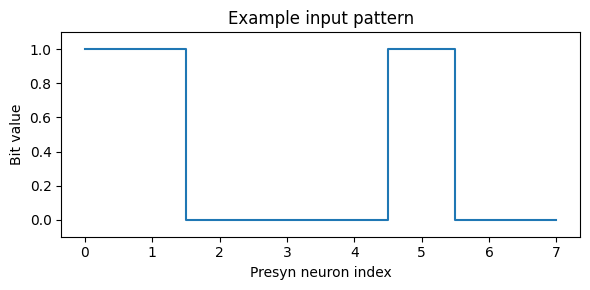

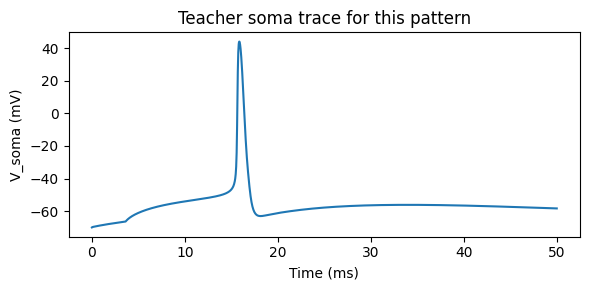

In [33]:
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [34]:
print("patterns shape:", patterns.shape)

for bad_idx in [200, 500, 10_000]:
    try:
        _ = patterns[bad_idx]
        print(f"Index {bad_idx} unexpectedly succeeded")
    except Exception as e:
        print(f"Index {bad_idx} raised: {repr(e)}")


patterns shape: (200, 8)
Index 200 unexpectedly succeeded
Index 500 unexpectedly succeeded
Index 10000 unexpectedly succeeded


OUT OF BOUNDS IS CLAMPED INTERNALLY? DEFAULTS TO LAST VALUE AKA IDX = 199

pattern_example shape: (8,)


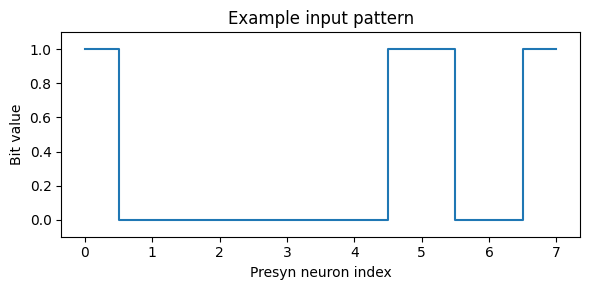

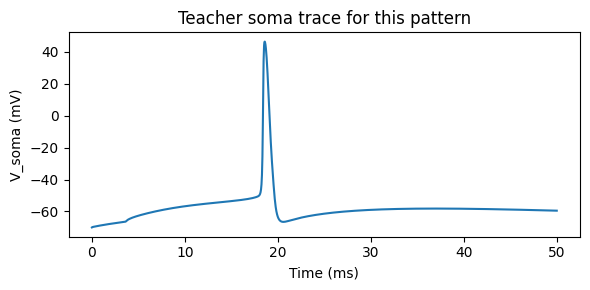

In [35]:
idx = 500
pattern_example = patterns[idx]
target_example  = targets[idx]   # shape (T,)
print("pattern_example shape:", pattern_example.shape)

# time axis from dt and T
T = target_example.shape[0]
time_vec = np.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(num_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [36]:
print("patterns[195]:", patterns[195])
print("patterns[196]:", patterns[196])
print("patterns[197]:", patterns[197])
print("patterns[198]:", patterns[198])

patterns[195]: [0. 0. 1. 0. 0. 1. 1. 0.]
patterns[196]: [0. 1. 1. 1. 1. 1. 1. 1.]
patterns[197]: [0. 1. 1. 1. 0. 0. 1. 0.]
patterns[198]: [1. 0. 1. 1. 1. 1. 1. 1.]


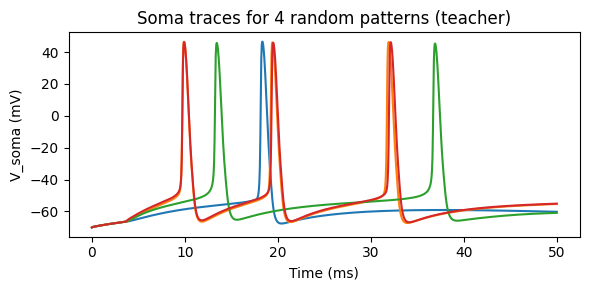

In [37]:
# run a small batch
traces = batched_simulate(params_true, patterns[195:199])  # (4, T)

T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces.T)   # traces.T has shape (T, 4)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces for 4 random patterns (teacher)")
plt.tight_layout()
plt.show()


In [38]:
traces = batched_simulate(params_true, patterns[196:199])
max_diff = np.max(np.abs(traces[0] - traces[2]))
print("max |difference| between trace 0 and 1:", float(max_diff))


max |difference| between trace 0 and 1: 80.08121191649411


In [39]:
traces = batched_simulate(params_true, patterns[196:197])  # indices 196,197,198
max_diff = np.max(np.abs(traces[0] - traces[4])) 
print("max |difference| between trace 0 and 1:", float(max_diff))         # 196 vs 197

pair = np.stack([patterns[196], patterns[198]], axis=0)   # shape (2, num_pre)
traces = batched_simulate(params_true, pair)              # shape (2, T)
max_diff = np.max(np.abs(traces[0] - traces[1]))
print("max |difference| between trace 0 and 1:", float(max_diff))

max |difference| between trace 0 and 1: 0.0
max |difference| between trace 0 and 1: 80.08121191649411


In [40]:
traces_batch = np.asarray(traces)   # make sure it's a NumPy array
n, T = traces_batch.shape

max_diffs = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        diff_ij = np.max(np.abs(traces_batch[i] - traces_batch[j]))
        max_diffs[i, j] = float(diff_ij)

print("pairwise max |difference|:")
print(max_diffs)

# Ignore self-comparisons
for i in range(n):
    max_diffs[i, i] = np.inf

# Find the closest pair
flat_idx = np.argmin(max_diffs)
i_min, j_min = divmod(flat_idx, n)

print(f"closest pair in this batch: {i_min} and {j_min}")
print(f"pattern indices in original array: {195 + i_min} and {195 + j_min}")
print(f"min max-diff: {max_diffs[i_min, j_min]:.6g}")


pairwise max |difference|:
[[ 0.         80.08121192]
 [80.08121192  0.        ]]
closest pair in this batch: 0 and 1
pattern indices in original array: 195 and 196
min max-diff: 80.0812


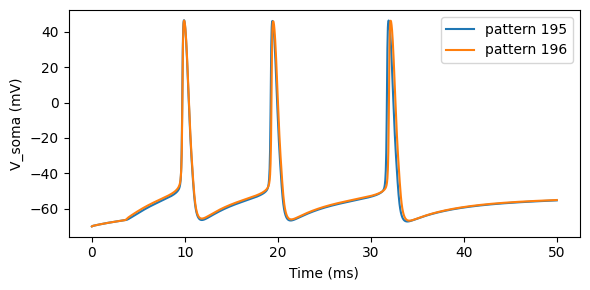

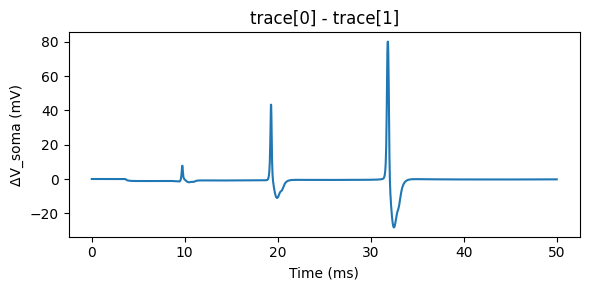

In [41]:
T = traces.shape[1]
time_vec = np.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0], label="pattern 195")
ax.plot(time_vec, traces[1], label="pattern 196")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0] - traces[1])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ΔV_soma (mV)")
ax.set_title("trace[0] - trace[1]")
plt.tight_layout()
plt.show()


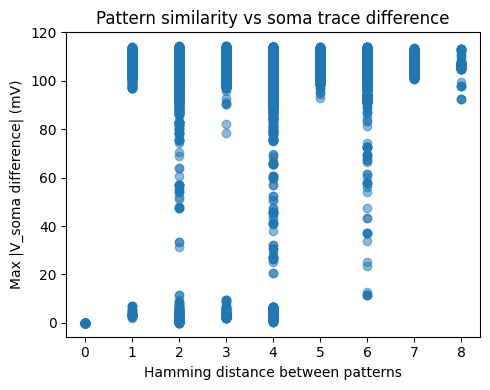

In [42]:
n_samples, num_pre = patterns.shape
_, T = targets.shape

# how many random pairs to sample
n_pairs = 100

rng = np.random.default_rng(0)

# sample random pairs (i, j), making sure i != j
idx_i = rng.integers(0, n_samples, size=n_pairs)
idx_j = rng.integers(0, n_samples, size=n_pairs)
mask = idx_i != idx_j
idx_i = idx_i[mask]
idx_j = idx_j[mask]

hamming_dists = []
max_diffs = []

for i in range(n_samples):
    for j in range(i+1, n_samples):
        h = int(np.sum(np.abs(patterns[i] - patterns[j])))
        d = float(np.max(np.abs(targets[i] - targets[j])))
        hamming_dists.append(h)
        max_diffs.append(d)

hamming_dists = np.array(hamming_dists)
max_diffs = np.array(max_diffs)

# scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(hamming_dists, max_diffs, alpha=0.5)
plt.xlabel("Hamming distance between patterns")
plt.ylabel("Max |V_soma difference| (mV)")
plt.title("Pattern similarity vs soma trace difference")
plt.tight_layout()
plt.show()


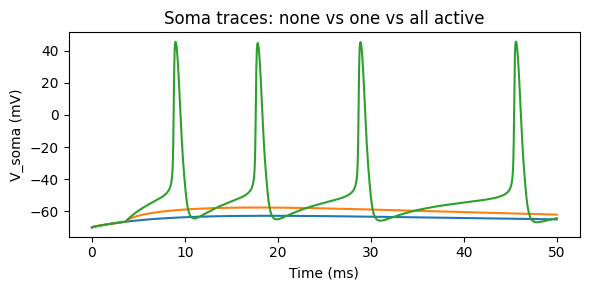

In [43]:
p_none = np.array([0, 0, 0, 0, 0.], dtype=np.float64)
p_one  = np.array([1, 0, 0, 0, 0.], dtype=np.float64)
p_all  = np.array([1, 1, 1, 1, 1.], dtype=np.float64)

ext_patterns = np.stack([p_none, p_one, p_all], axis=0)
ext_traces   = batched_simulate(params_true, ext_patterns)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, ext_traces.T)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces: none vs one vs all active")
plt.tight_layout()
plt.show()


SANITY DONE

TRAIN

In [44]:
key_learn = jax.random.PRNGKey(1)
noise_scale = 0.5

def add_noise_to_opt_params(opt_params, key, scale):
    leaves, treedef = jax.tree_util.tree_flatten(opt_params)
    subkeys = jax.random.split(key, len(leaves))
    noisy_leaves = [
        p + scale * jax.random.normal(k, p.shape)
        for p, k in zip(leaves, subkeys)
    ]
    return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)


In [45]:
print("opt_params_true:", opt_params_true)
print("opt_params_learn:", opt_params_learn)

opt_params_true: [{'IonotropicSynapse_gS': Array([-4.70048037, -4.70048037, -4.70048037, -4.70048037, -4.70048037,
       -4.70048037, -4.70048037, -4.70048037], dtype=float64)}]
opt_params_learn: [{'IonotropicSynapse_gS': Array([-4.15437057, -4.53451949, -5.15140135, -5.38955926, -4.48521748,
       -3.89707026, -4.6802116 , -5.09414458], dtype=float64)}]


In [46]:
def loss_fn(opt_params, patterns_batch, targets_batch):
    params = transform.forward(opt_params)
    preds = batched_simulate(params, patterns_batch)   # (B, T)
    return jnp.mean((preds - targets_batch) ** 2)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [47]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_params_learn)

num_steps = 500
print_every = 25

for step in range(num_steps + 1):
    train_loss, grads = grad_fn(opt_params_learn, patterns_train, targets_train)
    updates, opt_state = optimizer.update(grads, opt_state, opt_params_learn)
    opt_params_learn = optax.apply_updates(opt_params_learn, updates)

    if step % print_every == 0:
        val_loss = loss_fn(opt_params_learn, patterns_val, targets_val)
        print(f"step {step:4d} | train_loss={float(train_loss):.4e} "
              f"| val_loss={float(val_loss):.4e}")


step    0 | train_loss=4.8288e+02 | val_loss=4.9035e+02
step   25 | train_loss=2.8744e+02 | val_loss=3.4876e+02
step   50 | train_loss=2.7066e+02 | val_loss=3.2805e+02
step   75 | train_loss=2.5465e+02 | val_loss=3.1800e+02
step  100 | train_loss=2.4394e+02 | val_loss=3.0553e+02
step  125 | train_loss=2.3994e+02 | val_loss=3.0753e+02
step  150 | train_loss=2.4478e+02 | val_loss=3.0580e+02
step  175 | train_loss=2.4274e+02 | val_loss=3.0276e+02
step  200 | train_loss=2.4626e+02 | val_loss=3.0087e+02
step  225 | train_loss=2.3837e+02 | val_loss=2.9835e+02
step  250 | train_loss=2.3483e+02 | val_loss=2.9461e+02
step  275 | train_loss=2.3714e+02 | val_loss=2.9228e+02
step  300 | train_loss=2.3764e+02 | val_loss=2.9327e+02
step  325 | train_loss=2.3335e+02 | val_loss=2.8857e+02
step  350 | train_loss=2.3339e+02 | val_loss=2.8808e+02
step  375 | train_loss=2.3173e+02 | val_loss=2.8707e+02
step  400 | train_loss=2.3165e+02 | val_loss=2.8729e+02
step  425 | train_loss=2.2653e+02 | val_loss=2.7

In [48]:
train_loss_true = loss_fn(opt_params_true, patterns_train, targets_train)
val_loss_true   = loss_fn(opt_params_true, patterns_val, targets_val)
print("teacher train/val:", float(train_loss_true), float(val_loss_true))


teacher train/val: 0.0 0.0


In [49]:
params_learn_phys = transform.forward(opt_params_learn)
gS_true  = params_true[0]["IonotropicSynapse_gS"]
gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]

print("gS_true:",  gS_true)
print("gS_learn:", gS_learn)
print("max |diff|:", float(jnp.max(jnp.abs(gS_true - gS_learn))))


gS_true: [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
gS_learn: [1.21169967e-04 9.79599914e-05 8.25701583e-05 7.71413572e-05
 9.63577671e-05 1.34399900e-04 9.04082169e-05 8.66049197e-05]
max |diff|: 3.439989952502248e-05


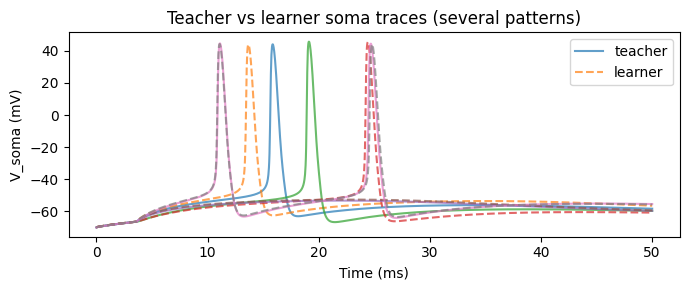

In [50]:
idxs = np.array([0, 1, 2, 3])  # any 4 indices < patterns_val.shape[0]

patterns_ex = patterns_train[idxs]       # (4, n_pre)
targets_ex  = targets_train[idxs]        # (4, T)


params_learn = transform.forward(opt_params_learn)


preds_ex = batched_simulate(params_learn, patterns_ex)   # (4, T)

T_ex = preds_ex.shape[1]
time_vec = np.arange(T_ex) * dt

plt.figure(figsize=(7, 3))
for i in range(len(idxs)):
    plt.plot(time_vec, targets_ex[i],       alpha=0.7, label="teacher" if i == 0 else None)
    plt.plot(time_vec, preds_ex[i], "--",   alpha=0.7, label="learner" if i == 0 else None)

plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs learner soma traces (several patterns)")
plt.legend()
plt.tight_layout()
plt.show()


GRADIENTS!

In [51]:
params_learn_phys = transform.forward(opt_params_learn)

In [52]:
def single_loss_phys(params_phys, pattern, target_trace):
    pred = simulate(params_phys, pattern)   # uses params_phys directly now
    return jnp.mean((pred - target_trace) ** 2)


In [53]:
idx = 0 
pattern_ex = patterns_train[idx]
target_ex  = targets_train[idx]    

loss_val, grads_phys = value_and_grad(single_loss_phys)(
    params_learn_phys, pattern_ex, target_ex
)

print("single-example loss:", float(loss_val))

# gradient wrt synaptic conductances
gS_grad = grads_phys[0]["IonotropicSynapse_gS"]   # ndarray
print("gS_grad shape:", gS_grad.shape)
print("gS_grad (first few):", gS_grad[:10])

gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]
print("gS_learn shape:", gS_learn.shape)
print("gS_learn (first few):", gS_learn[:10])


single-example loss: 265.3509249441007
gS_grad shape: (8,)
gS_grad (first few): [977571.86295737 928919.91664756 178775.8815969  155908.14361253
 134150.36800012 499253.32189267 107399.42046628 103459.70009068]
gS_learn shape: (8,)
gS_learn (first few): [1.21169967e-04 9.79599914e-05 8.25701583e-05 7.71413572e-05
 9.63577671e-05 1.34399900e-04 9.04082169e-05 8.66049197e-05]


In [54]:
single_grad_phys = jax.grad(single_loss_phys, argnums=0)

grads_phys_train = vmap(
    single_grad_phys,
    in_axes=(None, 0, 0),    # params shared, patterns/targets batched
)(params_learn_phys, patterns_train, targets_train)

gS_grad_train = grads_phys_train[0]["IonotropicSynapse_gS"]   # shape (N_val, 8)
print("gS_grad_val shape:", gS_grad_train.shape)  # (N_val, 8)
print("first pattern grad:", gS_grad_train[0])

gS_grad_val shape: (160, 8)
first pattern grad: [977571.86296144 928919.91665126 178775.88159759 155908.14361312
 134150.36800062 499253.32189439 107399.42046667 103459.70009105]


In [55]:
print("gS_grad_train (first 5 rows):\n", np.array(gS_grad_train[:5]))


gS_grad_train (first 5 rows):
 [[   977571.86296144    928919.91665126    178775.88159759
     155908.14361312    134150.36800062    499253.32189439
     107399.42046667    103459.70009105]
 [   -72838.71618564   -317642.23644243    -58511.29780347
    -242190.23015994    -43671.30283876    -37860.71467143
     -33672.52975539   -143425.98110236]
 [   143860.61414924     27356.50824949    118521.05321039
      21981.92218914     19795.49383521     18099.25659082
      17035.5164817      16558.52800489]
 [-14925197.27879747 -13694550.5876119   -2432481.08213463
   -9370462.29335228  -7489283.92803988  -1375972.44002101
   -5269140.54371963  -1136060.06560025]
 [ -1153735.4635602   -4936520.22993748  -4384779.63752581
   -3737375.37288314  -3127584.90807739   -657592.20262946
   -2351483.64652897   -574398.01380311]]


In [56]:
for n in range(5):
    print(f"pattern {n} bits:", patterns_train[n])
    print(f"gS_grad_train[{n}]:", gS_grad_train[n])
    print()


pattern 0 bits: [1. 1. 0. 0. 0. 1. 0. 0.]
gS_grad_train[0]: [977571.86296144 928919.91665126 178775.88159759 155908.14361312
 134150.36800062 499253.32189439 107399.42046667 103459.70009105]

pattern 1 bits: [0. 1. 0. 1. 0. 0. 0. 1.]
gS_grad_train[1]: [ -72838.71618564 -317642.23644243  -58511.29780347 -242190.23015994
  -43671.30283876  -37860.71467143  -33672.52975539 -143425.98110236]

pattern 2 bits: [1. 0. 1. 0. 0. 0. 0. 0.]
gS_grad_train[2]: [143860.61414924  27356.50824949 118521.05321039  21981.92218914
  19795.49383521  18099.25659082  17035.5164817   16558.52800489]

pattern 3 bits: [1. 1. 0. 1. 1. 0. 1. 0.]
gS_grad_train[3]: [-14925197.27879747 -13694550.5876119   -2432481.08213463
  -9370462.29335228  -7489283.92803988  -1375972.44002101
  -5269140.54371963  -1136060.06560025]

pattern 4 bits: [0. 1. 1. 1. 1. 0. 1. 0.]
gS_grad_train[4]: [-1153735.4635602  -4936520.22993748 -4384779.63752581 -3737375.37288314
 -3127584.90807739  -657592.20262946 -2351483.64652897  -574398.01

In [57]:
row_norms = jnp.linalg.norm(gS_grad_train, axis=1)
print("first 10 row norms:", row_norms[:10])


first 10 row norms: [ 1471154.60425068   439689.9091697    193024.70862829 24311764.76248444
  8658419.48211678 42684969.75093427 37748521.8780773  46603580.46654757
 42605325.16193672    83244.61570108]


DEFINE BIOPHYSICAL CORRELATES TO LOOK AT

In [58]:
# syn_post_comp_indices[i] = local compartment index on the post cell
# where synapse i was connected
# gradient gS_grad[i] refers to the same synapse i 

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
Nsyn = len(syn_post_comp_indices)

print(f"Nsyn = {Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

# print morphology table 
print(f"{'syn_i':>5} | {'pre_cell':>8} | {'post_comp_local':>15} | {'post_comp_global':>16}")
print("-" * 55)
for i in range(Nsyn):
    local_c = syn_post_comp_indices[i]
    global_c = num_pre + local_c   # post cell comps start at global index num_pre
    print(f"{i:>5} | {i:>8} | {local_c:>15} | {global_c:>16}")

# another sanity check to make sure the indexing is consitent with grads!!
print("\nQuick alignment check (pattern 0):")
print(f" bits = {np.array(patterns_train[0])}")
print(f"|grad_w|= {np.abs(np.array(gS_grad_train[0])).astype(int)}")


Nsyn = 8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]
syn_i | pre_cell | post_comp_local | post_comp_global
-------------------------------------------------------
    0 |        0 |               0 |                8
    1 |        1 |               2 |               10
    2 |        2 |               4 |               12
    3 |        3 |               6 |               14
    4 |        4 |               8 |               16
    5 |        5 |              10 |               18
    6 |        6 |              12 |               20
    7 |        7 |              14 |               22

Quick alignment check (pattern 0):
 bits = [1. 1. 0. 0. 0. 1. 0. 0.]
|grad_w|= [977571 928919 178775 155908 134150 499253 107399 103459]


On a given trial,  input pattern is binary: some presynaptic cells are on (receive injected current) and others are off. Each presynaptic cell connects to the postsynaptic neuron through one synapse ( IonotropicSynapse_gS[i]).

So on that trial, ff presyn cell i is off, that synapse basically doesn’t transmit anything (or transmits only baseline), so changing its conductance should barely change the postsynaptic voltage trace and so its gradient should be near 0.

If presyn cell i is on, that synapse contributes current into the postsynaptic cell. Changing gs should cause changes the postsynaptic trace, and thus the loss and so its gradient should be large/larger?

In [59]:
# copy of network for analysis (literally all from above in one block)
def build_net():
    _comp_pre = jx.Compartment()
    _branch_pre = jx.Branch(_comp_pre, ncomp=1)
    _cell_pre = jx.Cell(_branch_pre, parents=np.asarray([-1]))

    _comp_post = jx.Compartment()
    _branch_post = jx.Branch(_comp_post, ncomp=n_post_comp)
    _cell_post = jx.Cell(_branch_post, parents=np.asarray([-1]))

    _cells = [_cell_pre for _ in range(num_pre)] + [_cell_post]
    _net= jx.Network(_cells)

    _net.insert(Na())
    _net.insert(K())
    _net.insert(Leak())

    _syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            _net.cell(pre_i).branch(0).comp(0),
            _net.cell(post_idx).branch(0).comp(int(comp_i)),
            _syn,
        )
    return _net

net_analysis = build_net()
print(f"net_analysis: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")


net_analysis: 23 compartments, 8 edges


In [60]:
# recording setup 
def setup_recordings_for_synapses(net_obj, post_cell_idx, comp_indices):
    net_obj.delete_recordings()
    # record soma = comp 0  (here also the site of synapse 0)
    net_obj.cell(post_cell_idx).branch(0).comp(0).record()
    comp_indices_no0 = [ci for ci in comp_indices if int(ci) != 0]
    for ci in comp_indices_no0:
        net_obj.cell(post_cell_idx).branch(0).comp(int(ci)).record()
    return net_obj, comp_indices_no0

net_analysis, _syn_comp_no0 = setup_recordings_for_synapses(
    net_analysis, post_idx, syn_post_comp_indices
)

n_rec = 1 + len(_syn_comp_no0) # should equal Nsyn
assert n_rec == Nsyn, f"Expected {Nsyn} recordings, got {n_rec}"

# make synapses trainable
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

# reuse the same transform and  apply learned weights
params_analysis = transform.forward(opt_params_learn)

print(f"Recordings: 1(soma/syn0) + {len(_syn_comp_no0)} (syn 1‥{Nsyn-1})"
      f"= {n_rec} unique")
print(f"Learned gS:{params_analysis[0]['IonotropicSynapse_gS']}")

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Recordings: 1(soma/syn0) + 7 (syn 1‥7)= 8 unique
Learned gS:[1.21169967e-04 9.79599914e-05 8.25701583e-05 7.71413572e-05
 9.63577671e-05 1.34399900e-04 9.04082169e-05 8.66049197e-05]


In [61]:
def simulate_analysis(params_phys, pattern):
    """Run analysis net → all recordings shape (Nsyn, T).

    Layout:
      traces[0]       = comp 0  (soma / synapse 0)
      traces[1:Nsyn]  = comp 2,4,…,14  (synapses 1‥7)
    """
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces 
        

def unpack_traces(traces):
  # traces : (Nsyn, T)  from simulate_analysis
  # V_soma  : (T,)
  # V_local : (Nsyn-1, T)  — V_local[i] = voltage at synapse i's site
    V_soma = traces[0]             
    V_local = traces[1:]  
    V_all = traces                                 
    return V_soma, V_local, V_all


Raw traces shape: (8, 2002))
V_soma shape: (2002,)
V_local shape: (7, 2002)
V_all shape: (8, 2002)


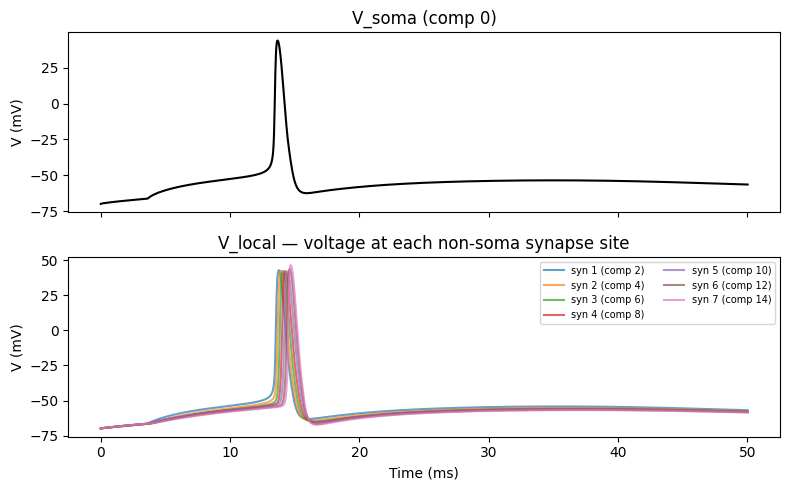

In [62]:
# verify recordings with one trial
test_traces = simulate_analysis(params_analysis, patterns_train[0])
print(f"Raw traces shape: {test_traces.shape})")
assert test_traces.shape[0] == Nsyn, \
    f"Expected {Nsyn} recordings, got {test_traces.shape[0]}"

# unpack into V_soma and V_local (synapse 0 → soma copy)
V_soma, V_local, V_all = unpack_traces(test_traces)
print(f"V_soma shape: {V_soma.shape}")
print(f"V_local shape: {V_local.shape}")
print(f"V_all shape: {V_all.shape}")

T = test_traces.shape[1]
tv = np.arange(T) * dt

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

axes[0].plot(tv, V_soma, "k", lw=1.5)
axes[0].set_ylabel("V (mV)")
axes[0].set_title("V_soma (comp 0)")

n_local = V_local.shape[0]
for i in range(n_local):
    syn_idx = i + 1
    comp_idx = syn_post_comp_indices[syn_idx] if syn_idx < len(syn_post_comp_indices) else "?"
    axes[1].plot(tv, V_local[i], alpha=0.7,
                 label=f"syn {syn_idx} (comp {comp_idx})")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("V (mV)")
axes[1].set_title("V_local — voltage at each non-soma synapse site")
axes[1].legend(fontsize=7, ncol=2)

plt.tight_layout()
plt.show()

In [63]:
# get grads and traces together 
def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)   # (Nsyn, T)
    soma_pred = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = vg_fn(params_phys, pattern, target)

    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    V_soma, V_local, V_all = unpack_traces(raw_traces)     # (T,), (Nsyn-1, T)

    return grad_w, V_soma, V_local, V_all, loss

gw, vs, vl, va, lo = single_trial(params_analysis, patterns_train[0], targets_train[0])

print(f"grad_w shape: {gw.shape}")
print(f"V_soma shape: {vs.shape}")
print(f"V_local shape: {vl.shape}")
print(f"V_all shape: {va.shape}")
print(f"loss = {float(lo):.4f}")
print(f"grad_w = {gw}")

# cross-check against gradients computed earlier (cell above)
print(f"\nEarlier gS_grad_train[0] = {gS_grad_train[0]}")
print(f"Max |diff| = {float(jnp.max(jnp.abs(gw - gS_grad_train[0]))):.2e}")


grad_w shape: (8,)
V_soma shape: (2002,)
V_local shape: (7, 2002)
V_all shape: (8, 2002)
loss = 265.3509
grad_w = [977571.86295737 928919.91664756 178775.8815969  155908.14361253
 134150.36800012 499253.32189267 107399.42046628 103459.70009068]

Earlier gS_grad_train[0] = [977571.86296144 928919.91665126 178775.88159759 155908.14361312
 134150.36800062 499253.32189439 107399.42046667 103459.70009105]
Max |diff| = 4.07e-06


In [64]:
# extract local physiology for N trials
N_trials = 500
key_data = jax.random.PRNGKey(42)

# fresh random binary patterns
patterns_data = jax.random.bernoulli(
    key_data, p=0.5, shape=(N_trials, num_pre)
).astype(jnp.float64)

# teacher targets (true params, original net)
targets_data = batched_simulate(params_true, patterns_data)   # (N, T)

print(f"patterns_data : {patterns_data.shape}")
print(f"targets_data : {targets_data.shape}")


patterns_data : (500, 8)
targets_data : (500, 2002)


In [65]:
# batched extraction: vmap value_and_grad over all trials
batched_vg = jit(
    jax.vmap(
        jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
        in_axes=(None, 0, 0),
    )
)


((losses_all, raw_traces_all), grads_all) = batched_vg(
    params_analysis, patterns_data, targets_data
)
# raw_traces_all shape: (N, Nsyn, T)
#  [:, 0, :] = comp 0  (soma / synapse 0)
#  [:, 1:Nsyn, :] = comp 2,4,…,14  (synapses 1‥7)

# unpack into numpy arrays
GRADS = np.asarray(grads_all[0]["IonotropicSynapse_gS"])  # (N, Nsyn)
VSOMA = np.asarray(raw_traces_all[:, 0, :])  # (N, T)
VLOCAL = np.asarray(raw_traces_all[:, 1:, :])  # (N, Nsyn-1, T)     
VALL = np.asarray(raw_traces_all)  # (N, Nsyn, T)
LOSSES = np.asarray(losses_all)  # (N,)

print(f"\nGRADS : {GRADS.shape}")
print(f"VSOMA: {VSOMA.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VALL: {VALL.shape}")
print(f"LOSSES: min={LOSSES.min():.1f}  mean={LOSSES.mean():.1f}  max={LOSSES.max():.1f}")

assert VALL.shape[1] == Nsyn, \
    f"Expected Nsyn={Nsyn} recordings, got {raw_traces_all.shape[1]}"
assert VLOCAL.shape[1] == Nsyn - 1, \
    f"Expected VLOCAL to have Nsyn-1={Nsyn-1} sites, got {VLOCAL.shape[1]}"



GRADS : (500, 8)
VSOMA: (500, 2002)
VLOCAL: (500, 7, 2002)
VALL: (500, 8, 2002)
LOSSES: min=0.0  mean=222.5  max=624.4


In [66]:
import os

save_dir  = "/n/home12/isanchez/jaxneuro/outputs"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "local_phys_dataset.npz")

np.savez(
    save_path,
    GRADS=GRADS,
    VSOMA=VSOMA,
    VLOCAL=VLOCAL,
    VALL=VALL,
    patterns=np.asarray(patterns_data),
    losses=LOSSES,
    syn_post_comp_indices=np.asarray(syn_post_comp_indices),
    dt=dt,
    t_max=t_max,
    i_delay=i_delay,
    i_dur=i_dur,
    N_trials=N_trials,
    Nsyn=Nsyn,
)

fsize = os.path.getsize(save_path)
print(f"Saved → {save_path}  ({fsize / 1e6:.1f} MB)")


Saved → /n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz  (128.2 MB)
